In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return allsubs

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['age', 'sex', 'wrat'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

830
(830, 264, 124)


In [3]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 1.83

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.2], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

ts = [np.stack([ts for ts in filter_design_ts(Xp)]) for Xp in X]
ts = [tsmod/np.linalg.norm(tsmod, axis=(-1), keepdims=True) for tsmod in ts]
print(ts[0].shape)

(830, 264, 124)


In [4]:
import sys

sys.path.append('../../LatentSimilarity')

from latsim import LatSim

print('Complete')

Complete


In [5]:
import itertools
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

class LowRankCodes(nn.Module):
    '''
    ranks: array of rank for each codebook matrix
    '''
    def __init__(self, ranks):
        super(LowRankCodes, self).__init__()
        self.As = []
        for rank in ranks:
            A = nn.Parameter(1e-2*torch.randn(rank,264).float().cuda())
            self.As.append(A)
        self.As = nn.ParameterList(self.As)

    def forward(self):
        book = []
        for A in self.As:
            AA = A.T@A
            book.append(AA)
        return torch.stack(book)
    
class LowRankWeights(nn.Module):
    '''
    For a single modality!
    
    nsubs: number of subjects
    ncodes: number of pages in the codebook
    nt: number of timepoints
    '''
    def __init__(self, nsubs, ncodes, nt):
        super(LowRankWeights, self).__init__()
        self.w = nn.Parameter(1e-2*torch.rand(nsubs, ncodes, nt).float().cuda())

    def forward(self, sub, book):
        w = self.w[sub]
        return torch.einsum('pt,pab->abt', w, book)
    
class MLP(nn.Module):
    def __init__(self, ncodes):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(ncodes, 40).float().cuda()
        self.l2 = nn.Linear(40,1).float().cuda()
        
    def train(self, xtr, ytr, nepochs=1000, lr=1e-1, l1=1e-1, l2=1e-4, pperiod=100, verbose=False):
        optim = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.75, eps=1e-7)
        
        for epoch in range(nepochs):
            optim.zero_grad()
            yhat = self(xtr)
            loss = mseLoss(yhat, ytr)**0.5
            l1loss = l1*torch.sum(torch.abs(self.l1.weight))
            (loss+l1loss).backward()
            optim.step()
            sched.step(loss)
            if verbose:
                if epoch % pperiod == 0 or epoch == nepochs-1:
                    print(f'{epoch} {[float(l) for l in [loss, l1loss]]} {sched._last_lr}')
                    
    def predict(self, xt, yt):
        with torch.no_grad():
            return mseLoss(self(xt), yt)**0.5
                    
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x).squeeze()
        return x
    
def get_recon_loss(x, xhat):
    return mseLoss(xhat, x)

def get_smooth_loss_fc(xhat):
    before = xhat[:,:,:-1]
    after = xhat[:,:,1:]
    return torch.mean((before-after)**2)

def get_sub_fc(subts):
    return torch.einsum('at,bt->abt',subts,subts)

mseLoss = nn.MSELoss()
        
mod = 'emoid'
modidx = 2
    
for ncodes in [10,50,100,200,300,400,500,600,800,1000,1200,1400,1600]:
    for split in range(3):

        # Timeseries
        x = torch.from_numpy(ts[modidx]).float().cuda()

        # Parameters
        ntrain = 350
        nbatch = 20
        smooth_mult = 0.1
        sparse_mult = 0#1e-3
        nEpochs = 60
        pPeriod = 40
        
        print(f'Starting ncodes {ncodes} split {split}')
        suborder = np.arange(x.shape[0])
        np.random.shuffle(suborder)
        suborder = suborder[:ntrain]

        # Codebook and weights
        lrc = LowRankCodes(ncodes*[1])
        lrw = LowRankWeights(ntrain, ncodes, x.shape[-1])

        # Optimizers
        optim = torch.optim.Adam(itertools.chain(lrc.parameters(), lrw.parameters()), lr=1e-2, weight_decay=0)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=int(ntrain/nbatch)+5, factor=0.75, eps=1e-7)

        t0 = time.time()

        for epoch in range(nEpochs):
            for bstart in range(0,ntrain,nbatch):
                bend = bstart+nbatch
                if bend > ntrain:
                    bend = ntrain
                optim.zero_grad()
                book = lrc()
                recon_loss = 0
                smooth_loss_fc = 0
                sparse_loss = 0
                for subidx in range(bstart, bend):
                    # THE FOLLOWING 3 LINES MEAN LRW.W DOESN'T MATCH SUBJECTS UNLESS WE MAP THROUGH SUBORDER
                    # WHICH IS OKAY SINCE WE RE-ESTIMATE WEIGHTS THROUGH THE DICTIONARY ANYWAY
                    sub = suborder[subidx]
                    xsub = get_sub_fc(x[sub])
                    xhat = lrw(subidx, book)       
                    recon_loss += get_recon_loss(xsub, xhat)
                    smooth_loss_fc += smooth_mult*get_smooth_loss_fc(xhat)
                recon_loss /= (bend-bstart)
                smooth_loss_fc /= (bend-bstart)
#                 sparse_loss = sparse_mult*torch.mean(torch.abs(lrw.w))
        #         sparse_loss = sparse_mult*torch.mean(lrw.w*torch.log(lrw.w))
                totloss = recon_loss+smooth_loss_fc+sparse_loss
                totloss.backward()
                optim.step()
                sched.step(totloss)
            if epoch % 5 == 0 or epoch == nEpochs-1:
                print(f'{epoch} {bstart} recon: {[float(ls)**0.5 for ls in [recon_loss, smooth_loss_fc, sparse_loss]]} '
                      f'lr: {sched._last_lr}')

        t1 = time.time()
        print(f'Completed dictionary estimation {t1-t0} sec')
        
        # Weight estimation
        book = lrc()

        A = book.reshape(book.shape[0], -1).permute(1,0)
        AA = A.T@A
        codes = []

        for sub in range(x.shape[0]):
            B = get_sub_fc(x[sub]).reshape(-1, x.shape[-1])
            AB = A.T@B
            C,_,_,_ = torch.linalg.lstsq(AA+0.1*torch.eye(AA.shape[0]).float().cuda(),AB)
            codes.append(torch.from_numpy(C.detach().cpu().numpy()))
            if sub % 100 == 0:
                loss = mseLoss(A@C,B)**0.5
                print(f'Finished {sub} {loss}')

        codes = torch.stack(codes)
        print(codes.shape)
        print('Finished weight estimation')
        
        trainsizes = [30,50,100,200,300,400,500,600,700,800]
        nreps = 10
        
        # Lstsq
        res = np.zeros((nreps,len(trainsizes)))
        l2 = 1e-2

        for rep in range(nreps):
            losses = []

            idcs = np.arange(codes.shape[0])
            np.random.shuffle(idcs)

            for ntrain in trainsizes:
                codescuda = codes.float().cuda()
                xps = torch.mean(codescuda, dim=-1)
                xps = torch.cat([xps, torch.ones(xps.shape[0], 1).float().cuda()], dim=1)
                xtr = xps[idcs[:ntrain]]
                xt = xps[idcs[ntrain:]]

                y = get_y(metadict, ['age'], subs)[0]
                y_t = torch.from_numpy(y).float().cuda()
                ytr = y_t[idcs[:ntrain]]
                yt = y_t[idcs[ntrain:]]

                # REDUCE THIS TO GET GOOD RESULTS WITH SPARSITY 0.01->0.001 or 0.0001
                w, _, _, _ = torch.linalg.lstsq(xtr.T@xtr + l2*torch.eye(ncodes+1).float().cuda(), xtr.T@ytr)

                print(torch.mean((yt-xt@w)**2)**0.5)
                losses.append(float(torch.mean((yt-xt@w)**2)**0.5))

            print(f'Finished {rep}')
            res[rep,:] = losses
            
        with open(f'/home/anton/Documents/Tulane/Research/Work/LatSimEC2/DictEst/{mod}-lstsq-mean.csv', 
                  'a') as f:
            f.write(f'{ncodes},{split},{",".join([str(val) for val in np.mean(res, axis=0)])}\n')
            
        with open(f'/home/anton/Documents/Tulane/Research/Work/LatSimEC2/DictEst/{mod}-lstsq-std.csv', 
                  'a') as f:
            f.write(f'{ncodes},{split},{",".join([str(val) for val in np.std(res, axis=0)])}\n')
        
        print(f'Finished lstsq')
        
        # MLP
        res = np.zeros((nreps,len(trainsizes)))

        for rep in range(nreps):

            idcs = np.arange(codes.shape[0])
            np.random.shuffle(idcs)

            losses = []

            for ntrain in trainsizes:
                codescuda = codes.float().cuda()
                xps = torch.mean(codescuda, dim=-1)
                xtr = xps[idcs[:ntrain]]
                xt = xps[idcs[ntrain:]]

                y = get_y(metadict, ['age'], subs)[0]
                y_t = torch.from_numpy(y).float().cuda()
                ytr = y_t[idcs[:ntrain]]
                yt = y_t[idcs[ntrain:]]

                mlp = MLP(ncodes)
                # 1e-3 good for age 1e-2 good for wrat
                mlp.train(xtr, ytr, lr=1e-2, nepochs=1000, l1=1e-3, l2=1e-4)
                loss = mlp.predict(xt, yt)

                losses.append(float(loss))
                print(float(loss))

            res[rep,:] = losses
            print(f'Finished {rep}')

        with open(f'/home/anton/Documents/Tulane/Research/Work/LatSimEC2/DictEst/{mod}-mlp-mean.csv', 
                  'a') as f:
            f.write(f'{ncodes},{split},{",".join([str(val) for val in np.mean(res, axis=0)])}\n')
            
        with open(f'/home/anton/Documents/Tulane/Research/Work/LatSimEC2/DictEst/{mod}-mlp-std.csv', 
                  'a') as f:
            f.write(f'{ncodes},{split},{",".join([str(val) for val in np.std(res, axis=0)])}\n')
            
        print(f'Finished mlp')
        
        # LatSim
        res = np.zeros((nreps,len(trainsizes)))

        nepochs = 500
        pperiod = 100
        verbose = False

        for rep in range(nreps):

            idcs = np.arange(codes.shape[0])
            np.random.shuffle(idcs)

            losses = []

            for ntrain in trainsizes:
                codescuda = codes.float().cuda()
                xps = torch.mean(codescuda[idcs], dim=-1).unsqueeze(1)

                mu = torch.mean(xps[:ntrain], dim=0, keepdims=True)
                std = torch.std(xps[:ntrain], dim=0, keepdims=True)
                xps = (xps-mu)/std

                xtr = xps[:ntrain]
                xt = xps[ntrain:]

                y = get_y(metadict, ['age'], subs)[0]
                y_t = torch.from_numpy(y[idcs]).float().cuda()
                ytr = y_t[:ntrain]
                yt = y_t[ntrain:]

                # dp=0.5 for wrat
                sim = LatSim(1, xps, dp=0.5, edp=0.1, wInit=1e-4, dim=2, temp=1)
                optim = torch.optim.Adam(sim.parameters(), lr=1e-3, weight_decay=1e-3)
                sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.75, eps=1e-7)

                for epoch in range(nepochs):
                    optim.zero_grad()
                    yhat = sim(xtr, [ytr])[0][0]
                    loss = mseLoss(yhat, ytr)**0.5
                    loss.backward()
                    optim.step()
                    sched.step(loss)
                    if verbose:
                        if epoch % pperiod == 0 or epoch == nepochs-1:
                            print(f'{epoch} {float(loss)} {sched._last_lr}')

                sim.eval()
                yhat = sim(xps, [y_t], np.arange(ntrain,idcs.shape[0]))[0][0][ntrain:]
                loss = mseLoss(yhat, yt)**0.5
                losses.append(float(loss))

                print(float(loss))

            res[rep,:] = losses
            print(f'Finished {rep}')
        
        with open(f'/home/anton/Documents/Tulane/Research/Work/LatSimEC2/DictEst/{mod}-latsim-mean.csv', 
                  'a') as f:
            f.write(f'{ncodes},{split},{",".join([str(val) for val in np.mean(res, axis=0)])}\n')
            
        with open(f'/home/anton/Documents/Tulane/Research/Work/LatSimEC2/DictEst/{mod}-latsim-std.csv', 
                  'a') as f:
            f.write(f'{ncodes},{split},{",".join([str(val) for val in np.std(res, axis=0)])}\n')
            
        print(f'Finished LatSim')

Starting ncodes 10 split 0
0 340 recon: [0.008165487142740034, 4.7043578473603677e-07, 0.0] lr: [0.01]
5 340 recon: [0.007501407943760078, 0.0016131723131781073, 0.0] lr: [0.0075]
10 340 recon: [0.006957814094707833, 0.0014976430382416571, 0.0] lr: [0.005625]
15 340 recon: [0.007183407944442816, 0.0024236800171794338, 0.0] lr: [0.005625]
20 340 recon: [0.006115129864682039, 0.0014926300967395623, 0.0] lr: [0.00421875]
25 340 recon: [0.006019169523045644, 0.001577396851087726, 0.0] lr: [0.0031640625]
30 340 recon: [0.005941132284198905, 0.0015702865917405794, 0.0] lr: [0.002373046875]
35 340 recon: [0.00590765453975945, 0.001588612960087351, 0.0] lr: [0.002373046875]
40 340 recon: [0.005881501184330562, 0.0016041227946256406, 0.0] lr: [0.002373046875]
45 340 recon: [0.005861398724916028, 0.0016164940717901949, 0.0] lr: [0.002373046875]
50 340 recon: [0.005873424541811458, 0.0016751740001911953, 0.0] lr: [0.002373046875]
55 340 recon: [0.006428225299861465, 0.002262098893688576, 0.0] lr:

38.22371292114258
Finished 6
40.02763366699219
38.773155212402344
37.00966262817383
37.446659088134766
37.781707763671875
36.936126708984375
37.4465446472168
37.69522476196289
39.25416564941406
36.340049743652344
Finished 7
39.22609329223633
38.83578872680664
37.268333435058594
37.83317947387695
38.187538146972656
38.416038513183594
38.06687927246094
38.10984802246094
37.578887939453125
40.096614837646484
Finished 8
41.459781646728516
38.72840118408203
37.566097259521484
38.2044792175293
36.96676254272461
37.464046478271484
36.79973602294922
37.04672622680664
36.644596099853516
37.869842529296875
Finished 9
Finished LatSim
Starting ncodes 10 split 1
0 340 recon: [0.010419493468003662, 4.307705442634417e-07, 0.0] lr: [0.01]
5 340 recon: [0.009498636023503017, 0.0017306477357959635, 0.0] lr: [0.0075]
10 340 recon: [0.008381910353127688, 0.0012696804086669588, 0.0] lr: [0.00421875]
15 340 recon: [0.00815210757375549, 0.002251436418695877, 0.0] lr: [0.00421875]
20 340 recon: [0.00727671951

36.788482666015625
35.8317756652832
35.4799690246582
35.872291564941406
35.361568450927734
38.31333541870117
Finished 3
38.83696365356445
39.27806091308594
38.70606994628906
37.198360443115234
36.66234588623047
36.79060745239258
37.18952178955078
37.39101791381836
37.92958450317383
34.37000274658203
Finished 4
38.850685119628906
40.59487533569336
39.17742919921875
38.152957916259766
38.06586456298828
37.956382751464844
38.94000244140625
38.558406829833984
37.91680145263672
35.54237365722656
Finished 5
39.715370178222656
39.76694107055664
38.699378967285156
38.35354995727539
38.57054901123047
38.015201568603516
37.97841262817383
37.7234992980957
37.644927978515625
34.731510162353516
Finished 6
39.0011100769043
39.731327056884766
39.36479949951172
38.373294830322266
37.87413024902344
38.85826873779297
39.37117385864258
38.093788146972656
38.88156509399414
38.75967025756836
Finished 7
38.58735275268555
38.85002899169922
39.0750617980957
38.35935592651367
37.62455368041992
37.3206558227539

39.12903594970703
38.801979064941406
37.28995895385742
37.80916976928711
38.00676345825195
37.68587875366211
37.71179962158203
37.16585922241211
37.152626037597656
39.0986328125
Finished 0
39.81846237182617
39.675174713134766
40.080142974853516
39.91883850097656
38.15903091430664
37.83015060424805
37.30744934082031
39.20857238769531
37.66985321044922
39.90764236450195
Finished 1
40.597225189208984
38.97014236450195
38.22844696044922
37.30976104736328
37.80116271972656
37.769866943359375
37.46849060058594
37.52284240722656
38.5443000793457
40.876068115234375
Finished 2
39.307090759277344
39.41339874267578
38.71939468383789
37.679988861083984
37.75257110595703
37.82421875
37.55181121826172
37.878379821777344
38.1052131652832
38.404232025146484
Finished 3
40.10858917236328
37.9895133972168
38.84865188598633
38.14879608154297
37.96444320678711
37.36702346801758
37.42728805541992
37.81105041503906
37.640750885009766
35.81643295288086
Finished 4
39.76627731323242
39.53828430175781
38.5886993

39.64910888671875
39.3904914855957
37.073333740234375
36.71363067626953
36.73738098144531
37.521793365478516
36.595054626464844
36.81072998046875
37.02759552001953
40.375118255615234
Finished 7
37.5341911315918
37.44955825805664
37.857566833496094
38.28922653198242
37.44634246826172
37.171875
37.691505432128906
38.11474609375
37.39882278442383
39.584999084472656
Finished 8
38.374717712402344
36.95039749145508
36.79931640625
36.4265251159668
36.05134582519531
36.52738952636719
36.56206130981445
37.18274688720703
37.74424743652344
36.5216064453125
Finished 9
Finished mlp
38.762454986572266
38.30144500732422
36.310646057128906
35.042388916015625
33.812232971191406
33.377235412597656
33.595516204833984
34.40774154663086
35.049190521240234
33.10354232788086
Finished 0
36.393402099609375
36.10842514038086
35.14500045776367
34.551910400390625
34.154178619384766
34.100860595703125
33.8126220703125
33.11167907714844
34.030521392822266
34.00629425048828
Finished 1
39.20099639892578
38.1103744506

38.057186126708984
38.58409118652344
38.81669235229492
38.36312484741211
37.34416198730469
37.96181869506836
37.45901107788086
37.12209701538086
37.752784729003906
41.86978530883789
Finished 4
36.49700164794922
36.63728332519531
36.36661148071289
36.73830032348633
37.017250061035156
36.93948745727539
37.14311599731445
37.196781158447266
35.54541015625
39.41522216796875
Finished 5
39.80600357055664
38.572410583496094
37.33430099487305
38.577964782714844
38.09434127807617
37.9702262878418
38.8129997253418
38.56281661987305
38.65623092651367
35.767520904541016
Finished 6
37.314414978027344
37.31916046142578
37.04812240600586
37.281524658203125
36.675567626953125
37.08588409423828
36.05204391479492
37.22999572753906
38.76161575317383
38.40410614013672
Finished 7
36.81848907470703
36.858070373535156
37.91058349609375
36.88432312011719
37.31881332397461
37.1965446472168
36.30935287475586
37.60675048828125
36.75130844116211
37.402679443359375
Finished 8
43.10811996459961
37.99637222290039
36.

36.3167839050293
36.94850540161133
36.70183181762695
35.553035736083984
36.39962387084961
37.119422912597656
37.81460189819336
37.119998931884766
36.14111328125
43.520713806152344
Finished 1
39.93500900268555
38.38065719604492
37.925148010253906
38.19855880737305
37.947486877441406
38.400840759277344
37.8541374206543
37.32508850097656
37.00878143310547
34.24372482299805
Finished 2
36.49717712402344
36.744319915771484
37.47549819946289
37.28544616699219
35.44976043701172
37.058406829833984
37.09792709350586
36.939762115478516
36.9998779296875
34.45815658569336
Finished 3
40.07218933105469
37.47718048095703
37.01999282836914
36.509864807128906
35.336734771728516
36.318336486816406
36.23758316040039
36.24464797973633
37.389617919921875
37.45632553100586
Finished 4
38.049861907958984
36.85252380371094
37.34724426269531
37.44015121459961
36.75297164916992
36.348960876464844
35.95674133300781
36.12053298950195
34.71129608154297
34.785579681396484
Finished 5
38.46824645996094
38.1655235290527

39.892356872558594
37.93943786621094
35.20725631713867
36.090721130371094
35.95400619506836
36.90679168701172
37.565185546875
36.20634841918945
37.66069412231445
34.78017044067383
Finished 0
38.31219482421875
34.695587158203125
35.842227935791016
36.236305236816406
36.437705993652344
35.60776901245117
36.373008728027344
35.3351936340332
37.523399353027344
44.60661697387695
Finished 1
39.5895881652832
40.55739212036133
38.12823486328125
35.3319206237793
35.297122955322266
35.95354080200195
37.12117004394531
37.10207748413086
36.71993637084961
34.58755111694336
Finished 2
39.183685302734375
39.258052825927734
36.312217712402344
36.38269805908203
36.869930267333984
36.55303192138672
37.42726516723633
38.14513397216797
38.73472595214844
38.333091735839844
Finished 3
37.839202880859375
37.22148513793945
36.95103454589844
36.36913299560547
36.187461853027344
36.96599578857422
36.14341735839844
35.05390930175781
36.521331787109375
31.690738677978516
Finished 4
37.00281524658203
37.66853713989

tensor(31.6233, device='cuda:0')
tensor(31.5114, device='cuda:0')
tensor(27.0608, device='cuda:0')
Finished 8
tensor(37.7599, device='cuda:0')
tensor(37.0192, device='cuda:0')
tensor(35.5901, device='cuda:0')
tensor(34.2352, device='cuda:0')
tensor(33.8880, device='cuda:0')
tensor(32.9905, device='cuda:0')
tensor(32.8956, device='cuda:0')
tensor(31.8657, device='cuda:0')
tensor(33.5534, device='cuda:0')
tensor(31.5588, device='cuda:0')
Finished 9
Finished lstsq
40.849708557128906
37.62135314941406
34.82770538330078
34.72307586669922
34.32173538208008
34.047245025634766
33.92134094238281
33.79045867919922
33.07084274291992
36.71458435058594
Finished 0
42.05232620239258
36.05292892456055
35.44548797607422
33.8913459777832
35.02067184448242
33.875003814697266
34.213558197021484
33.867286682128906
34.44926834106445
34.65420150756836
Finished 1
40.43662643432617
35.772674560546875
34.58893966674805
33.168251037597656
34.387664794921875
33.67929458618164
32.31681442260742
31.37462615966797
3

tensor(32.8228, device='cuda:0')
tensor(31.6682, device='cuda:0')
tensor(32.2009, device='cuda:0')
tensor(29.6001, device='cuda:0')
tensor(32.4544, device='cuda:0')
Finished 7
tensor(38.2088, device='cuda:0')
tensor(38.6810, device='cuda:0')
tensor(37.3798, device='cuda:0')
tensor(34.8070, device='cuda:0')
tensor(34.1794, device='cuda:0')
tensor(32.6826, device='cuda:0')
tensor(33.1576, device='cuda:0')
tensor(32.7497, device='cuda:0')
tensor(31.5338, device='cuda:0')
tensor(28.9904, device='cuda:0')
Finished 8
tensor(38.0982, device='cuda:0')
tensor(37.3547, device='cuda:0')
tensor(35.7361, device='cuda:0')
tensor(34.2916, device='cuda:0')
tensor(33.2120, device='cuda:0')
tensor(32.7971, device='cuda:0')
tensor(32.7447, device='cuda:0')
tensor(32.4740, device='cuda:0')
tensor(32.0377, device='cuda:0')
tensor(29.5663, device='cuda:0')
Finished 9
Finished lstsq
39.98765563964844
36.39229965209961
35.12523651123047
36.759769439697266
35.45283126831055
34.783992767333984
35.63777923583984

tensor(32.7926, device='cuda:0')
tensor(32.2242, device='cuda:0')
Finished 5
tensor(38.8280, device='cuda:0')
tensor(36.1126, device='cuda:0')
tensor(34.6635, device='cuda:0')
tensor(34.1370, device='cuda:0')
tensor(32.9299, device='cuda:0')
tensor(32.2895, device='cuda:0')
tensor(31.2070, device='cuda:0')
tensor(30.7383, device='cuda:0')
tensor(30.7119, device='cuda:0')
tensor(30.7290, device='cuda:0')
Finished 6
tensor(36.0916, device='cuda:0')
tensor(35.6394, device='cuda:0')
tensor(35.6894, device='cuda:0')
tensor(33.8122, device='cuda:0')
tensor(32.8883, device='cuda:0')
tensor(32.8755, device='cuda:0')
tensor(32.7944, device='cuda:0')
tensor(32.0257, device='cuda:0')
tensor(29.9270, device='cuda:0')
tensor(32.8850, device='cuda:0')
Finished 7
tensor(37.3525, device='cuda:0')
tensor(36.4741, device='cuda:0')
tensor(35.1825, device='cuda:0')
tensor(34.0871, device='cuda:0')
tensor(32.8480, device='cuda:0')
tensor(32.5476, device='cuda:0')
tensor(32.4138, device='cuda:0')
tensor(32.

tensor(32.3604, device='cuda:0')
tensor(32.0070, device='cuda:0')
tensor(31.3530, device='cuda:0')
tensor(30.3977, device='cuda:0')
tensor(29.1507, device='cuda:0')
tensor(30.1202, device='cuda:0')
Finished 4
tensor(36.8338, device='cuda:0')
tensor(35.8892, device='cuda:0')
tensor(35.7568, device='cuda:0')
tensor(34.3953, device='cuda:0')
tensor(32.6168, device='cuda:0')
tensor(31.6724, device='cuda:0')
tensor(30.9803, device='cuda:0')
tensor(31.1243, device='cuda:0')
tensor(29.9292, device='cuda:0')
tensor(25.8604, device='cuda:0')
Finished 5
tensor(38.2407, device='cuda:0')
tensor(38.2468, device='cuda:0')
tensor(36.3350, device='cuda:0')
tensor(33.7189, device='cuda:0')
tensor(32.2861, device='cuda:0')
tensor(31.2522, device='cuda:0')
tensor(30.9082, device='cuda:0')
tensor(30.8015, device='cuda:0')
tensor(29.0710, device='cuda:0')
tensor(25.9112, device='cuda:0')
Finished 6
tensor(38.5665, device='cuda:0')
tensor(37.2531, device='cuda:0')
tensor(34.9797, device='cuda:0')
tensor(34.

tensor(36.4445, device='cuda:0')
tensor(35.5094, device='cuda:0')
tensor(34.2918, device='cuda:0')
tensor(33.1306, device='cuda:0')
tensor(31.9676, device='cuda:0')
tensor(30.7782, device='cuda:0')
tensor(29.9154, device='cuda:0')
tensor(29.9817, device='cuda:0')
tensor(30.3283, device='cuda:0')
tensor(28.8869, device='cuda:0')
Finished 3
tensor(37.4499, device='cuda:0')
tensor(36.1417, device='cuda:0')
tensor(34.8029, device='cuda:0')
tensor(33.6769, device='cuda:0')
tensor(32.4764, device='cuda:0')
tensor(31.4820, device='cuda:0')
tensor(30.5486, device='cuda:0')
tensor(30.4183, device='cuda:0')
tensor(28.5019, device='cuda:0')
tensor(28.1168, device='cuda:0')
Finished 4
tensor(38.5623, device='cuda:0')
tensor(36.5476, device='cuda:0')
tensor(35.7619, device='cuda:0')
tensor(33.0104, device='cuda:0')
tensor(32.7364, device='cuda:0')
tensor(30.9572, device='cuda:0')
tensor(31.0291, device='cuda:0')
tensor(30.2120, device='cuda:0')
tensor(28.8698, device='cuda:0')
tensor(26.7862, devic

tensor(30.7025, device='cuda:0')
tensor(29.9411, device='cuda:0')
tensor(30.0956, device='cuda:0')
tensor(29.7255, device='cuda:0')
tensor(26.2310, device='cuda:0')
Finished 1
tensor(38.0105, device='cuda:0')
tensor(36.4061, device='cuda:0')
tensor(34.8166, device='cuda:0')
tensor(33.2224, device='cuda:0')
tensor(32.2670, device='cuda:0')
tensor(31.9544, device='cuda:0')
tensor(29.4234, device='cuda:0')
tensor(29.0576, device='cuda:0')
tensor(27.9741, device='cuda:0')
tensor(30.2649, device='cuda:0')
Finished 2
tensor(38.0226, device='cuda:0')
tensor(36.3802, device='cuda:0')
tensor(34.2891, device='cuda:0')
tensor(32.4058, device='cuda:0')
tensor(31.3923, device='cuda:0')
tensor(30.2972, device='cuda:0')
tensor(30.0353, device='cuda:0')
tensor(29.6995, device='cuda:0')
tensor(29.6977, device='cuda:0')
tensor(32.4839, device='cuda:0')
Finished 3
tensor(37.4981, device='cuda:0')
tensor(37.2382, device='cuda:0')
tensor(34.4918, device='cuda:0')
tensor(33.0675, device='cuda:0')
tensor(31.

Finished 500 0.004664701409637928
Finished 600 0.004373347852379084
Finished 700 0.004712061025202274
Finished 800 0.0037819892168045044
torch.Size([830, 300, 210])
Finished weight estimation
tensor(36.7188, device='cuda:0')
tensor(35.2967, device='cuda:0')
tensor(35.5005, device='cuda:0')
tensor(34.7620, device='cuda:0')
tensor(34.0039, device='cuda:0')
tensor(32.7592, device='cuda:0')
tensor(32.8217, device='cuda:0')
tensor(32.1677, device='cuda:0')
tensor(32.2568, device='cuda:0')
tensor(34.4986, device='cuda:0')
Finished 0
tensor(35.6351, device='cuda:0')
tensor(35.1143, device='cuda:0')
tensor(35.3048, device='cuda:0')
tensor(33.7983, device='cuda:0')
tensor(31.9711, device='cuda:0')
tensor(30.5279, device='cuda:0')
tensor(30.6410, device='cuda:0')
tensor(31.0209, device='cuda:0')
tensor(30.5113, device='cuda:0')
tensor(26.4420, device='cuda:0')
Finished 1
tensor(37.2048, device='cuda:0')
tensor(37.1922, device='cuda:0')
tensor(35.8977, device='cuda:0')
tensor(33.8180, device='cud

40 340 recon: [0.0047758532004605, 0.0013137003470367972, 0.0] lr: [0.002373046875]
45 340 recon: [0.004735369537685312, 0.001331033296309445, 0.0] lr: [0.002373046875]
50 340 recon: [0.004698578858585585, 0.0013448723105397313, 0.0] lr: [0.002373046875]
55 340 recon: [0.004664776624139664, 0.001356490085346633, 0.0] lr: [0.002373046875]
59 340 recon: [0.004639738557856542, 0.001364850640584261, 0.0] lr: [0.002373046875]
Completed dictionary estimation 435.9225182533264 sec
Finished 0 0.004008109215646982
Finished 100 0.006132776383310556
Finished 200 0.004063587635755539
Finished 300 0.004580636043101549
Finished 400 0.006593763362616301
Finished 500 0.004574973601847887
Finished 600 0.004346427973359823
Finished 700 0.004622023086994886
Finished 800 0.00375003251247108
torch.Size([830, 300, 210])
Finished weight estimation
tensor(37.3895, device='cuda:0')
tensor(36.0486, device='cuda:0')
tensor(35.0098, device='cuda:0')
tensor(33.2601, device='cuda:0')
tensor(32.0220, device='cuda:0'

0 340 recon: [0.007702474112539967, 2.8542566445342895e-06, 0.0] lr: [0.01]
5 340 recon: [0.007293575477315085, 0.0013526351088412926, 0.0] lr: [0.0075]
10 340 recon: [0.00606048525349177, 0.001051369760703858, 0.0] lr: [0.005625]
15 340 recon: [0.005547269950136477, 0.0012192622636722022, 0.0] lr: [0.005625]
20 340 recon: [0.010629867662450554, 0.005611772999379455, 0.0] lr: [0.005625]
25 340 recon: [0.005151952028409093, 0.0012975065023245777, 0.0] lr: [0.0031640625]
30 340 recon: [0.005021951879482472, 0.0013442197645162945, 0.0] lr: [0.0031640625]
35 340 recon: [0.004912629766193887, 0.0013762799161949448, 0.0] lr: [0.0031640625]
40 340 recon: [0.0048139338967182425, 0.0014029542704967716, 0.0] lr: [0.0031640625]
45 340 recon: [0.004727130116108845, 0.0014285168251845328, 0.0] lr: [0.0031640625]
50 340 recon: [0.00789400238666826, 0.004161936770061167, 0.0] lr: [0.0031640625]
55 340 recon: [0.004624284451271983, 0.0014445006305190264, 0.0] lr: [0.0017797851562500002]
59 340 recon: 

29.08370018005371
29.708324432373047
Finished 6
36.397071838378906
36.03247833251953
33.21604537963867
30.828535079956055
29.671112060546875
29.515806198120117
28.896512985229492
29.201589584350586
29.453142166137695
28.970319747924805
Finished 7
42.55001449584961
40.58485412597656
35.05815505981445
31.86422348022461
28.913236618041992
28.594987869262695
27.7933349609375
27.06385612487793
27.307538986206055
25.407644271850586
Finished 8
35.237632751464844
35.03950881958008
33.31110763549805
30.703351974487305
29.33209228515625
29.934307098388672
29.39558219909668
27.259532928466797
28.464311599731445
29.271682739257812
Finished 9
Finished LatSim
Starting ncodes 400 split 1
0 340 recon: [0.006469449338731564, 2.8454730491346165e-06, 0.0] lr: [0.01]
5 340 recon: [0.009295053738175527, 0.0007919878709080109, 0.0] lr: [0.0075]
10 340 recon: [0.005356973611260426, 0.0008671092303189933, 0.0] lr: [0.0075]
15 340 recon: [0.005026098350821018, 0.0010696164293610897, 0.0] lr: [0.0075]
20 340 re

29.391542434692383
29.23471450805664
28.505496978759766
27.814701080322266
26.126087188720703
26.900175094604492
Finished 3
36.40400695800781
35.865989685058594
34.95853805541992
31.195825576782227
29.01010513305664
29.107816696166992
29.48353385925293
30.402135848999023
31.612022399902344
32.06922149658203
Finished 4
35.72175216674805
35.056495666503906
34.39283752441406
31.682918548583984
29.968109130859375
28.26972198486328
29.300395965576172
29.951068878173828
28.459449768066406
25.657711029052734
Finished 5
35.76888656616211
33.18168640136719
32.31452178955078
30.778902053833008
29.711483001708984
29.2161922454834
28.76761817932129
27.962326049804688
27.16847801208496
31.229063034057617
Finished 6
36.006752014160156
34.44418716430664
33.062747955322266
30.230880737304688
28.600940704345703
28.20403289794922
28.209392547607422
27.30586814880371
26.640766143798828
28.537982940673828
Finished 7
36.91643524169922
34.51622772216797
32.91530227661133
30.681472778320312
28.53617286682129

35.60613250732422
35.548309326171875
33.64134216308594
31.306119918823242
30.997087478637695
30.159231185913086
29.486042022705078
29.20241355895996
28.9323787689209
31.650257110595703
Finished 0
35.091548919677734
35.11008071899414
33.57196044921875
31.414064407348633
29.986534118652344
29.922237396240234
28.440101623535156
27.86595344543457
28.37410545349121
26.5621337890625
Finished 1
35.61982727050781
35.13408660888672
32.92060089111328
31.237016677856445
30.204557418823242
28.810426712036133
29.355438232421875
30.273378372192383
31.895517349243164
35.93600082397461
Finished 2
36.313289642333984
35.09160232543945
34.954593658447266
31.371416091918945
29.88610076904297
27.192216873168945
27.6732234954834
26.226871490478516
26.78360366821289
27.82571792602539
Finished 3
38.975830078125
33.72908401489258
33.10731887817383
30.801090240478516
30.754619598388672
29.142751693725586
27.482364654541016
27.98383140563965
27.032011032104492
25.7984561920166
Finished 4
39.06808090209961
39.153

31.225332260131836
30.358882904052734
30.805423736572266
28.908771514892578
29.746410369873047
31.64040184020996
Finished 6
38.92049026489258
38.28770065307617
35.17061996459961
32.5251579284668
31.325822830200195
31.890119552612305
31.092796325683594
30.307741165161133
29.72271156311035
31.550397872924805
Finished 7
39.98915100097656
39.64082336425781
35.74988555908203
33.401527404785156
32.29310989379883
30.97873878479004
30.431306838989258
29.741954803466797
27.677593231201172
22.037641525268555
Finished 8
37.01751708984375
39.166725158691406
35.62263488769531
33.256500244140625
30.529937744140625
29.754175186157227
30.438629150390625
30.726818084716797
32.08401107788086
27.454071044921875
Finished 9
Finished mlp
34.944618225097656
35.40667724609375
34.12332534790039
31.925819396972656
29.88664436340332
28.24886703491211
28.088932037353516
26.8004150390625
26.428491592407227
29.904396057128906
Finished 0
36.98213195800781
36.38105773925781
31.902870178222656
30.356353759765625
29.77

34.205482482910156
30.58422088623047
Finished 2
40.410377502441406
37.84262466430664
35.81848907470703
31.956649780273438
33.60930633544922
31.378334045410156
30.155574798583984
31.203359603881836
29.90106964111328
26.33907699584961
Finished 3
37.569244384765625
37.935089111328125
35.53620910644531
32.2220573425293
32.17851638793945
32.05697250366211
31.089406967163086
31.052263259887695
29.53934669494629
31.285545349121094
Finished 4
41.139644622802734
40.791412353515625
37.39865493774414
35.549625396728516
32.6442756652832
33.97394943237305
33.59763717651367
32.992130279541016
31.319290161132812
31.401784896850586
Finished 5
38.83097457885742
38.65023422241211
36.4999885559082
33.35298538208008
31.733808517456055
30.638652801513672
29.884592056274414
29.424821853637695
30.791259765625
29.474849700927734
Finished 6
42.30007553100586
40.892311096191406
36.285362243652344
33.12241744995117
32.40618896484375
32.50407791137695
31.00952911376953
30.768983840942383
30.291828155517578
34.935

tensor(28.5486, device='cuda:0')
tensor(28.8984, device='cuda:0')
Finished 9
Finished lstsq
40.814151763916016
42.420494079589844
36.36164855957031
34.15157699584961
31.228900909423828
31.264162063598633
31.8450870513916
32.168418884277344
30.781110763549805
30.49245262145996
Finished 0
37.78276824951172
43.75238037109375
37.97373580932617
34.219112396240234
33.42328643798828
32.09708786010742
30.995004653930664
28.886890411376953
29.947416305541992
29.8087158203125
Finished 1
38.69510269165039
38.47599411010742
35.70587921142578
32.561214447021484
31.813982009887695
31.51685333251953
31.950847625732422
33.14059066772461
33.226890563964844
35.092288970947266
Finished 2
40.68399429321289
42.174827575683594
35.88972091674805
33.161598205566406
32.64870071411133
30.922788619995117
30.397663116455078
30.4982852935791
30.984148025512695
28.074634552001953
Finished 3
37.73052215576172
38.900657653808594
36.31610107421875
32.942596435546875
31.708040237426758
31.907072067260742
31.22580718994

tensor(39.3765, device='cuda:0')
tensor(36.3366, device='cuda:0')
tensor(33.3222, device='cuda:0')
tensor(32.2544, device='cuda:0')
tensor(30.3356, device='cuda:0')
tensor(28.8971, device='cuda:0')
tensor(28.9163, device='cuda:0')
tensor(28.0160, device='cuda:0')
tensor(27.6449, device='cuda:0')
tensor(26.5018, device='cuda:0')
Finished 8
tensor(42.1361, device='cuda:0')
tensor(36.6484, device='cuda:0')
tensor(34.1882, device='cuda:0')
tensor(32.6503, device='cuda:0')
tensor(30.9323, device='cuda:0')
tensor(29.9611, device='cuda:0')
tensor(28.6903, device='cuda:0')
tensor(28.7476, device='cuda:0')
tensor(28.2992, device='cuda:0')
tensor(26.9681, device='cuda:0')
Finished 9
Finished lstsq
37.57401657104492
39.880943298339844
39.72451400756836
34.47285079956055
32.11285400390625
31.51842498779297
31.029813766479492
32.45528793334961
32.225440979003906
36.05107879638672
Finished 0
36.88205337524414
39.092193603515625
37.244503021240234
32.4649543762207
31.42059326171875
30.150714874267578

tensor(35.7420, device='cuda:0')
tensor(33.6088, device='cuda:0')
tensor(31.8446, device='cuda:0')
tensor(30.9922, device='cuda:0')
tensor(30.7669, device='cuda:0')
tensor(29.5673, device='cuda:0')
tensor(28.6976, device='cuda:0')
tensor(22.2941, device='cuda:0')
Finished 6
tensor(36.9840, device='cuda:0')
tensor(35.7421, device='cuda:0')
tensor(33.6653, device='cuda:0')
tensor(32.5934, device='cuda:0')
tensor(30.4851, device='cuda:0')
tensor(30.3993, device='cuda:0')
tensor(29.5027, device='cuda:0')
tensor(28.0580, device='cuda:0')
tensor(27.6468, device='cuda:0')
tensor(32.5226, device='cuda:0')
Finished 7
tensor(36.9874, device='cuda:0')
tensor(35.8470, device='cuda:0')
tensor(35.8038, device='cuda:0')
tensor(33.3383, device='cuda:0')
tensor(32.4736, device='cuda:0')
tensor(31.0476, device='cuda:0')
tensor(29.5094, device='cuda:0')
tensor(29.2886, device='cuda:0')
tensor(27.3843, device='cuda:0')
tensor(24.4384, device='cuda:0')
Finished 8
tensor(37.6289, device='cuda:0')
tensor(37.

tensor(31.7670, device='cuda:0')
tensor(31.4360, device='cuda:0')
tensor(30.3352, device='cuda:0')
tensor(29.3582, device='cuda:0')
tensor(29.1686, device='cuda:0')
tensor(28.2316, device='cuda:0')
Finished 4
tensor(37.0324, device='cuda:0')
tensor(36.3553, device='cuda:0')
tensor(35.9800, device='cuda:0')
tensor(34.0750, device='cuda:0')
tensor(32.6630, device='cuda:0')
tensor(30.7981, device='cuda:0')
tensor(30.6462, device='cuda:0')
tensor(29.9920, device='cuda:0')
tensor(31.3526, device='cuda:0')
tensor(29.1699, device='cuda:0')
Finished 5
tensor(39.6019, device='cuda:0')
tensor(38.2962, device='cuda:0')
tensor(36.5942, device='cuda:0')
tensor(33.4548, device='cuda:0')
tensor(31.9984, device='cuda:0')
tensor(30.4160, device='cuda:0')
tensor(29.4912, device='cuda:0')
tensor(30.0738, device='cuda:0')
tensor(30.1249, device='cuda:0')
tensor(34.4671, device='cuda:0')
Finished 6
tensor(38.3189, device='cuda:0')
tensor(36.6391, device='cuda:0')
tensor(34.7175, device='cuda:0')
tensor(32.

tensor(31.1300, device='cuda:0')
tensor(30.5431, device='cuda:0')
tensor(29.1433, device='cuda:0')
tensor(27.8403, device='cuda:0')
tensor(29.6548, device='cuda:0')
Finished 2
tensor(37.3065, device='cuda:0')
tensor(36.9826, device='cuda:0')
tensor(34.8403, device='cuda:0')
tensor(33.1226, device='cuda:0')
tensor(31.5284, device='cuda:0')
tensor(30.0507, device='cuda:0')
tensor(30.0016, device='cuda:0')
tensor(30.0010, device='cuda:0')
tensor(29.8349, device='cuda:0')
tensor(20.4532, device='cuda:0')
Finished 3
tensor(37.3454, device='cuda:0')
tensor(37.0762, device='cuda:0')
tensor(33.9012, device='cuda:0')
tensor(31.5750, device='cuda:0')
tensor(30.4987, device='cuda:0')
tensor(29.6384, device='cuda:0')
tensor(29.0409, device='cuda:0')
tensor(28.0418, device='cuda:0')
tensor(25.9066, device='cuda:0')
tensor(25.1944, device='cuda:0')
Finished 4
tensor(41.5642, device='cuda:0')
tensor(37.5814, device='cuda:0')
tensor(35.2666, device='cuda:0')
tensor(33.0909, device='cuda:0')
tensor(32.

tensor(29.1710, device='cuda:0')
tensor(29.4437, device='cuda:0')
tensor(29.2733, device='cuda:0')
tensor(29.5164, device='cuda:0')
tensor(30.8155, device='cuda:0')
Finished 0
tensor(37.4645, device='cuda:0')
tensor(35.7850, device='cuda:0')
tensor(33.9909, device='cuda:0')
tensor(32.4453, device='cuda:0')
tensor(32.0373, device='cuda:0')
tensor(30.5309, device='cuda:0')
tensor(29.4141, device='cuda:0')
tensor(28.4703, device='cuda:0')
tensor(28.9091, device='cuda:0')
tensor(27.8791, device='cuda:0')
Finished 1
tensor(37.3822, device='cuda:0')
tensor(36.7990, device='cuda:0')
tensor(35.3551, device='cuda:0')
tensor(33.3458, device='cuda:0')
tensor(31.3280, device='cuda:0')
tensor(29.6644, device='cuda:0')
tensor(28.9089, device='cuda:0')
tensor(28.7961, device='cuda:0')
tensor(29.8766, device='cuda:0')
tensor(33.5431, device='cuda:0')
Finished 2
tensor(40.6575, device='cuda:0')
tensor(37.3274, device='cuda:0')
tensor(34.2632, device='cuda:0')
tensor(32.0045, device='cuda:0')
tensor(30.

59 340 recon: [0.0054637117719045026, 0.0021671886357128673, 0.0] lr: [0.0017797851562500002]
Completed dictionary estimation 675.7611207962036 sec
Finished 0 0.003925125580281019
Finished 100 0.0054297070018947124
Finished 200 0.003985072486102581
Finished 300 0.004534570965915918
Finished 400 0.0059003378264606
Finished 500 0.004510282073169947
Finished 600 0.004300808068364859
Finished 700 0.004557659383863211
Finished 800 0.003669730620458722
torch.Size([830, 800, 210])
Finished weight estimation
tensor(37.1699, device='cuda:0')
tensor(34.8970, device='cuda:0')
tensor(33.2178, device='cuda:0')
tensor(31.2582, device='cuda:0')
tensor(30.2556, device='cuda:0')
tensor(29.0336, device='cuda:0')
tensor(29.4230, device='cuda:0')
tensor(30.3254, device='cuda:0')
tensor(29.9038, device='cuda:0')
tensor(37.3216, device='cuda:0')
Finished 0
tensor(36.0472, device='cuda:0')
tensor(35.2079, device='cuda:0')
tensor(33.6132, device='cuda:0')
tensor(32.3999, device='cuda:0')
tensor(31.1320, devic

20 340 recon: [0.005075394143736253, 0.001056269541831348, 0.0] lr: [0.00421875]
25 340 recon: [0.004926736346215532, 0.0011252141034177581, 0.0] lr: [0.00421875]
30 340 recon: [0.005110206672204352, 0.001476532323810355, 0.0] lr: [0.0017797851562500002]
35 340 recon: [0.004816551749447526, 0.0011541621049040315, 0.0] lr: [0.0013348388671875003]
40 340 recon: [0.00478807194469655, 0.0011635607845627762, 0.0] lr: [0.0013348388671875003]
45 340 recon: [0.004760905524349577, 0.0011716615272432005, 0.0] lr: [0.0013348388671875003]
50 340 recon: [0.004734696112908322, 0.0011791789568531069, 0.0] lr: [0.0013348388671875003]
55 340 recon: [0.004709245319451179, 0.0011864904361813557, 0.0] lr: [0.0013348388671875003]
59 340 recon: [0.004689390102867713, 0.0011923882118643442, 0.0] lr: [0.0013348388671875003]
Completed dictionary estimation 755.4395134449005 sec
Finished 0 0.003981162793934345
Finished 100 0.006067068316042423
Finished 200 0.004035722464323044
Finished 300 0.004574331920593977


35.74026107788086
32.83183288574219
30.815771102905273
29.67333984375
28.510746002197266
27.420713424682617
26.281360626220703
24.907054901123047
23.866689682006836
Finished 8
33.35919189453125
33.16350555419922
33.36942672729492
31.98865509033203
30.2208194732666
28.134183883666992
27.482181549072266
26.206754684448242
27.497589111328125
27.61510467529297
Finished 9
Finished LatSim
Starting ncodes 1000 split 1
0 340 recon: [0.007927085023365027, 4.497103769371093e-06, 0.0] lr: [0.01]
5 340 recon: [0.008111260593273493, 0.0014141089709773904, 0.0] lr: [0.0075]
10 340 recon: [0.006093622474814691, 0.0013445753959181012, 0.0] lr: [0.0075]
15 340 recon: [0.005861525960341569, 0.002143754226824245, 0.0] lr: [0.005625]
20 340 recon: [0.006814054978788326, 0.003149715282577043, 0.0] lr: [0.005625]
25 340 recon: [0.005710276898331984, 0.0022666853431445155, 0.0] lr: [0.005625]
30 340 recon: [0.00697510093127098, 0.0034338712088876843, 0.0] lr: [0.005625]
35 340 recon: [0.005249897854905752, 0

24.90911102294922
Finished 4
35.58504867553711
35.48664093017578
34.53962707519531
30.446596145629883
28.9783878326416
28.388696670532227
27.26787757873535
26.92110252380371
26.504104614257812
27.689409255981445
Finished 5
35.703941345214844
36.43391418457031
33.27719497680664
30.259565353393555
28.79502296447754
26.95221519470215
26.225399017333984
25.20842933654785
24.38231658935547
27.7281494140625
Finished 6
37.18785095214844
36.275360107421875
32.311073303222656
29.560348510742188
28.52749252319336
27.02072525024414
27.401884078979492
27.024906158447266
27.49365997314453
28.30215835571289
Finished 7
39.05500030517578
37.41653823852539
33.73723220825195
29.44538116455078
27.69986915588379
27.532941818237305
25.385915756225586
25.66478729248047
26.324485778808594
22.580970764160156
Finished 8
36.03709030151367
35.52426528930664
32.07636642456055
29.27773666381836
28.84319305419922
28.131956100463867
28.035646438598633
27.691007614135742
26.503841400146484
26.109506607055664
Finished

27.5864315032959
28.003408432006836
27.243362426757812
27.578556060791016
Finished 1
36.135215759277344
33.47758865356445
32.06721115112305
30.92144775390625
29.81041145324707
28.61952781677246
28.22348403930664
27.296321868896484
25.25741958618164
22.401355743408203
Finished 2
38.079490661621094
36.59501647949219
32.82939147949219
31.622098922729492
29.96364402770996
29.297945022583008
28.10181427001953
28.40791893005371
28.561767578125
28.10611343383789
Finished 3
38.39881896972656
35.18012237548828
31.904081344604492
30.2594051361084
29.268035888671875
28.626239776611328
28.52521514892578
28.151262283325195
26.384056091308594
25.45826530456543
Finished 4
40.83739471435547
37.61617660522461
33.585052490234375
30.98687171936035
28.788904190063477
27.4691104888916
28.05135726928711
27.61681365966797
26.806962966918945
20.813396453857422
Finished 5
36.170379638671875
34.15922927856445
31.786277770996094
30.586227416992188
28.328351974487305
27.62192153930664
26.64266014099121
25.7611465

33.09324645996094
33.99168014526367
33.276371002197266
33.831626892089844
33.25811004638672
35.23446273803711
34.08937454223633
Finished 8
36.36555862426758
38.85874938964844
36.06071090698242
33.800167083740234
33.39274597167969
31.37343406677246
34.3535041809082
32.15052032470703
28.4882869720459
29.775423049926758
Finished 9
Finished mlp
36.430450439453125
34.79665756225586
33.675697326660156
30.611360549926758
29.11740493774414
29.308961868286133
26.843814849853516
26.172855377197266
26.39133644104004
28.878385543823242
Finished 0
39.739402770996094
38.84384536743164
33.248924255371094
30.72291374206543
28.364490509033203
27.971952438354492
27.731618881225586
28.323514938354492
28.899808883666992
32.30605697631836
Finished 1
36.243247985839844
34.75767517089844
33.33150863647461
30.53156852722168
29.82432746887207
29.50383186340332
28.34835433959961
28.471389770507812
26.264402389526367
24.412979125976562
Finished 2
38.01115417480469
36.1196403503418
32.21181106567383
30.3601608276

27.569608688354492
Finished 4
38.664791107177734
38.52849197387695
39.964378356933594
33.433250427246094
30.786460876464844
29.85397720336914
33.657596588134766
32.45396423339844
32.869842529296875
36.275028228759766
Finished 5
37.734832763671875
37.10663604736328
38.326541900634766
32.6278190612793
31.434789657592773
32.13688659667969
32.93972396850586
30.632568359375
31.608230590820312
35.683990478515625
Finished 6
37.57969284057617
37.701751708984375
37.38112258911133
33.652347564697266
33.52628707885742
31.8646297454834
32.08557891845703
33.62552261352539
32.555625915527344
31.41636085510254
Finished 7
36.67155456542969
35.73556137084961
39.73466873168945
32.58355712890625
33.405460357666016
33.424163818359375
33.556602478027344
34.181541442871094
32.464054107666016
37.79128646850586
Finished 8
37.861873626708984
41.41274642944336
39.32754898071289
33.94888687133789
30.9721736907959
32.81193923950195
30.66697883605957
31.897768020629883
33.08320236206055
28.17867088317871
Finished 

32.319801330566406
30.107385635375977
30.316253662109375
29.396467208862305
30.990123748779297
Finished 1
42.17798614501953
38.556278228759766
35.00414276123047
32.480621337890625
32.14874267578125
31.655790328979492
31.40032196044922
31.08478355407715
32.514102935791016
26.596572875976562
Finished 2
37.95078659057617
37.29414367675781
36.22530746459961
33.703548431396484
32.53046798706055
31.05906867980957
32.05750274658203
34.22978973388672
36.03404998779297
33.294795989990234
Finished 3
38.15572738647461
40.83776092529297
35.930328369140625
33.075462341308594
32.34766387939453
30.696029663085938
32.18954849243164
31.847949981689453
29.379249572753906
29.030601501464844
Finished 4
39.2034797668457
39.229713439941406
38.40211868286133
32.67476272583008
31.567291259765625
31.95494842529297
32.16965103149414
32.450130462646484
29.545360565185547
33.09580612182617
Finished 5
36.60704803466797
37.70494079589844
34.487998962402344
31.418909072875977
33.249881744384766
29.71526527404785
30.

tensor(39.2556, device='cuda:0')
tensor(36.8613, device='cuda:0')
tensor(34.8573, device='cuda:0')
tensor(32.6339, device='cuda:0')
tensor(32.2458, device='cuda:0')
tensor(29.9044, device='cuda:0')
tensor(30.2506, device='cuda:0')
tensor(28.5007, device='cuda:0')
tensor(28.8702, device='cuda:0')
tensor(29.6754, device='cuda:0')
Finished 9
Finished lstsq
36.452903747558594
37.09639358520508
36.15953826904297
34.42121887207031
32.08457946777344
33.04012680053711
33.724281311035156
32.14790344238281
31.07025909423828
33.38947296142578
Finished 0
37.882720947265625
39.22196578979492
36.76900100708008
32.505245208740234
31.956951141357422
32.8444709777832
31.005563735961914
30.615306854248047
30.635883331298828
33.1499137878418
Finished 1
36.619815826416016
37.67615509033203
36.81568908691406
30.967439651489258
31.5643253326416
31.045143127441406
31.771778106689453
31.81707763671875
33.40005874633789
32.000980377197266
Finished 2
37.132164001464844
37.88783645629883
35.2334098815918
33.5481

tensor(37.7801, device='cuda:0')
tensor(38.6322, device='cuda:0')
tensor(34.9516, device='cuda:0')
tensor(31.5098, device='cuda:0')
tensor(30.3250, device='cuda:0')
tensor(30.3217, device='cuda:0')
tensor(30.3233, device='cuda:0')
tensor(31.7034, device='cuda:0')
tensor(31.4052, device='cuda:0')
tensor(26.7894, device='cuda:0')
Finished 7
tensor(41.0305, device='cuda:0')
tensor(38.7123, device='cuda:0')
tensor(35.4534, device='cuda:0')
tensor(32.3541, device='cuda:0')
tensor(30.5156, device='cuda:0')
tensor(30.4771, device='cuda:0')
tensor(30.2185, device='cuda:0')
tensor(30.0304, device='cuda:0')
tensor(27.7435, device='cuda:0')
tensor(30.6651, device='cuda:0')
Finished 8
tensor(37.6467, device='cuda:0')
tensor(36.0617, device='cuda:0')
tensor(33.4611, device='cuda:0')
tensor(31.3312, device='cuda:0')
tensor(31.6363, device='cuda:0')
tensor(30.7119, device='cuda:0')
tensor(29.8742, device='cuda:0')
tensor(29.8751, device='cuda:0')
tensor(29.0722, device='cuda:0')
tensor(23.4662, devic

tensor(36.5054, device='cuda:0')
tensor(34.3898, device='cuda:0')
tensor(33.6495, device='cuda:0')
tensor(32.4434, device='cuda:0')
tensor(30.3737, device='cuda:0')
tensor(29.5833, device='cuda:0')
tensor(29.6128, device='cuda:0')
tensor(29.0499, device='cuda:0')
tensor(27.8089, device='cuda:0')
Finished 5
tensor(37.3014, device='cuda:0')
tensor(36.4556, device='cuda:0')
tensor(33.9115, device='cuda:0')
tensor(32.9295, device='cuda:0')
tensor(31.5678, device='cuda:0')
tensor(30.9026, device='cuda:0')
tensor(30.0137, device='cuda:0')
tensor(28.9094, device='cuda:0')
tensor(26.5848, device='cuda:0')
tensor(30.1101, device='cuda:0')
Finished 6
tensor(39.5756, device='cuda:0')
tensor(37.6595, device='cuda:0')
tensor(36.0312, device='cuda:0')
tensor(32.4442, device='cuda:0')
tensor(31.6736, device='cuda:0')
tensor(30.1752, device='cuda:0')
tensor(29.1705, device='cuda:0')
tensor(28.1336, device='cuda:0')
tensor(26.6281, device='cuda:0')
tensor(32.7404, device='cuda:0')
Finished 7
tensor(37.

tensor(34.4970, device='cuda:0')
tensor(32.3448, device='cuda:0')
tensor(30.5391, device='cuda:0')
tensor(29.5808, device='cuda:0')
tensor(28.5789, device='cuda:0')
tensor(27.2576, device='cuda:0')
tensor(25.9040, device='cuda:0')
tensor(27.4584, device='cuda:0')
Finished 3
tensor(37.6291, device='cuda:0')
tensor(35.9392, device='cuda:0')
tensor(33.9497, device='cuda:0')
tensor(32.8689, device='cuda:0')
tensor(32.7055, device='cuda:0')
tensor(31.5000, device='cuda:0')
tensor(30.7387, device='cuda:0')
tensor(29.5195, device='cuda:0')
tensor(29.1734, device='cuda:0')
tensor(27.5351, device='cuda:0')
Finished 4
tensor(38.0997, device='cuda:0')
tensor(37.7312, device='cuda:0')
tensor(35.5718, device='cuda:0')
tensor(32.6727, device='cuda:0')
tensor(31.1570, device='cuda:0')
tensor(30.9173, device='cuda:0')
tensor(30.3422, device='cuda:0')
tensor(29.4451, device='cuda:0')
tensor(27.9376, device='cuda:0')
tensor(23.2145, device='cuda:0')
Finished 5
tensor(38.7860, device='cuda:0')
tensor(35.

tensor(34.3582, device='cuda:0')
tensor(32.6099, device='cuda:0')
tensor(31.0771, device='cuda:0')
tensor(29.5945, device='cuda:0')
tensor(30.4576, device='cuda:0')
tensor(28.2828, device='cuda:0')
tensor(28.1665, device='cuda:0')
tensor(25.7790, device='cuda:0')
Finished 1
tensor(38.3363, device='cuda:0')
tensor(35.1772, device='cuda:0')
tensor(33.3736, device='cuda:0')
tensor(31.1886, device='cuda:0')
tensor(30.8374, device='cuda:0')
tensor(28.9818, device='cuda:0')
tensor(28.2923, device='cuda:0')
tensor(26.6609, device='cuda:0')
tensor(26.6127, device='cuda:0')
tensor(27.2391, device='cuda:0')
Finished 2
tensor(37.9922, device='cuda:0')
tensor(36.4514, device='cuda:0')
tensor(35.1462, device='cuda:0')
tensor(32.7350, device='cuda:0')
tensor(32.0259, device='cuda:0')
tensor(30.7421, device='cuda:0')
tensor(29.1454, device='cuda:0')
tensor(27.4829, device='cuda:0')
tensor(26.2342, device='cuda:0')
tensor(29.8291, device='cuda:0')
Finished 3
tensor(35.7887, device='cuda:0')
tensor(35.

Finished 400 0.006135168951004744
Finished 500 0.004420769400894642
Finished 600 0.004250793717801571
Finished 700 0.004517984110862017
Finished 800 0.0036049368791282177
torch.Size([830, 1600, 210])
Finished weight estimation
tensor(36.8665, device='cuda:0')
tensor(36.2823, device='cuda:0')
tensor(36.5382, device='cuda:0')
tensor(33.7003, device='cuda:0')
tensor(32.0204, device='cuda:0')
tensor(30.0124, device='cuda:0')
tensor(28.8949, device='cuda:0')
tensor(27.0064, device='cuda:0')
tensor(24.4202, device='cuda:0')
tensor(20.8102, device='cuda:0')
Finished 0
tensor(37.7801, device='cuda:0')
tensor(35.9714, device='cuda:0')
tensor(34.2887, device='cuda:0')
tensor(32.3469, device='cuda:0')
tensor(30.5101, device='cuda:0')
tensor(30.0227, device='cuda:0')
tensor(28.7648, device='cuda:0')
tensor(28.1136, device='cuda:0')
tensor(29.3242, device='cuda:0')
tensor(37.4854, device='cuda:0')
Finished 1
tensor(38.6831, device='cuda:0')
tensor(36.6275, device='cuda:0')
tensor(33.9993, device='c

In [8]:
import numpy as np

','.join([str(x) for x in np.array([1,2.0,3])])

'1.0,2.0,3.0'

In [123]:
# Fast weight estimation for all subjects

book = lrc()

A = book.reshape(book.shape[0], -1).permute(1,0)
AA = A.T@A
codes = []

for sub in range(x.shape[0]):
    B = get_sub_fc(x[sub]).reshape(-1, x.shape[-1])
    AB = A.T@B
    C,_,_,_ = torch.linalg.lstsq(AA+0.1*torch.eye(AA.shape[0]).float().cuda(),AB)
    codes.append(torch.from_numpy(C.detach().cpu().numpy()))
    if sub % 100 == 0:
        loss = mseLoss(A@C,B)**0.5
        print(f'Finished {sub} {loss}')
    
codes = torch.stack(codes)
print(codes.shape)

Finished 0 0.0039785257540643215
Finished 100 0.005333082750439644
Finished 200 0.0038813131395727396
Finished 300 0.005037365481257439
Finished 400 0.004587509203702211
Finished 500 0.004405444022268057
Finished 600 0.004049917217344046
Finished 700 0.004348925314843655
Finished 800 0.003647332079708576
torch.Size([830, 400, 231])


0.22894431251116604
0.23296103663912465
0.23395241538044612


/tmp/ipykernel_4966/2861173576.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


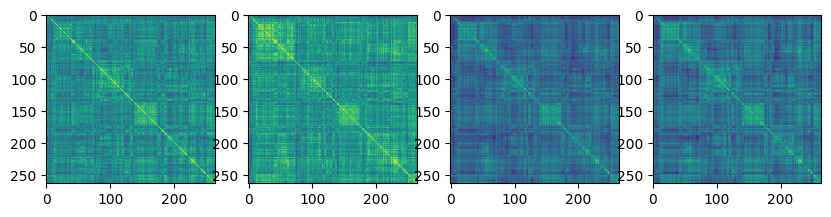

In [124]:
# Reconstruct static FC from dynamic FC

import matplotlib.pyplot as plt

sub = 200

dynfc = get_sub_fc(x[suborder[sub]])
dynfc = torch.mean(dynfc, dim=-1).detach().cpu().numpy()

statfc = np.corrcoef(ts[0][suborder[sub]])

reconfc = lrw(sub, book)
reconfc = torch.mean(reconfc, dim=-1).detach().cpu().numpy()

A = book.reshape(book.shape[0], -1).permute(1,0)
reconfc2 = torch.mean(A.cpu()@codes[suborder[sub]].cpu(), dim=1).reshape(264,264).detach().cpu().numpy()

fig, ax = plt.subplots(1,4,figsize=(10,3))

print(np.mean((statfc-124*dynfc)**2)**0.5)
print(np.mean((statfc-124*reconfc)**2)**0.5)
print(np.mean((statfc-124*reconfc2)**2)**0.5)

ax[0].imshow(dynfc)
ax[1].imshow(statfc)
ax[2].imshow(reconfc)
ax[3].imshow(reconfc2)
fig.show()

In [125]:
nreps = 10
trainsizes = [30,50,100,200,300,400,500,600,700,800]
res = np.zeros((nreps,len(trainsizes)))

for rep in range(nreps):
    dct = dict()
    for l2 in [1e-2]: #1e-3 good for age 1e-2 good for wrat
        losses = []

        idcs = np.arange(codes.shape[0])
        np.random.shuffle(idcs)

        for ntrain in trainsizes:
            codescuda = codes.float().cuda()
            xps = torch.mean(codescuda, dim=-1)
            xps = torch.cat([xps, torch.ones(xps.shape[0], 1).float().cuda()], dim=1)
            xtr = xps[idcs[:ntrain]]
            xt = xps[idcs[ntrain:]]

            y = get_y(metadict, ['age'], subs)[0]
            y_t = torch.from_numpy(y).float().cuda()
            ytr = y_t[idcs[:ntrain]]
            yt = y_t[idcs[ntrain:]]

            # REDUCE THIS TO GET GOOD RESULTS WITH SPARSITY 0.01->0.001 or 0.0001
            w, _, _, _ = torch.linalg.lstsq(xtr.T@xtr + l2*torch.eye(ncodes+1).float().cuda(), xtr.T@ytr)

        #     print(torch.mean((ytr-xtr@w)**2)**0.5)
            losses.append(float(torch.mean((yt-xt@w)**2)**0.5))
            
        dct[l2] = losses
    
    valmin = float('inf')
    valsav = None
    keysav = None
    
    for key,val in dct.items():
        this = np.mean(val[4:-1])
        if this < valmin:
            valsav = val
            valmin = this
            keysav = key
#     print(keysav)
    
    res[rep,:] = valsav
    
print(np.mean(res, axis=0))
print(np.std(res, axis=0))

[38.09110527 37.27643585 35.89479179 34.5914566  33.93579674 33.50535049
 32.58813572 32.08820858 32.23105164 31.95988903]
[1.44828901 1.241131   0.43254127 0.54604297 0.67821111 0.90194749
 0.76752532 0.56943666 1.70506429 2.51174095]


In [126]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, ncodes):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(ncodes, 40).float().cuda()
        self.l2 = nn.Linear(40,1).float().cuda()
        
    def train(self, xtr, ytr, nepochs=1000, lr=1e-1, l1=1e-1, l2=1e-4, pperiod=100, verbose=False):
        optim = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.75, eps=1e-7)
        
        for epoch in range(nepochs):
            optim.zero_grad()
            yhat = self(xtr)
            loss = mseLoss(yhat, ytr)**0.5
            l1loss = l1*torch.sum(torch.abs(self.l1.weight))
            (loss+l1loss).backward()
            optim.step()
            sched.step(loss)
            if verbose:
                if epoch % pperiod == 0 or epoch == nepochs-1:
                    print(f'{epoch} {[float(l) for l in [loss, l1loss]]} {sched._last_lr}')
                    
    def predict(self, xt, yt):
        with torch.no_grad():
            return mseLoss(self(xt), yt)**0.5
                    
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x).squeeze()
        return x

nreps = 10
trainsizes = [30,50,100,200,300,400,500,600,700,800]
res = np.zeros((nreps,len(trainsizes)))

for rep in range(nreps):

    idcs = np.arange(codes.shape[0])
    np.random.shuffle(idcs)
    
    losses = []

    for ntrain in trainsizes:
        codescuda = codes.float().cuda()
        xps = torch.mean(codescuda, dim=-1)
        xtr = xps[idcs[:ntrain]]
        xt = xps[idcs[ntrain:]]

        y = get_y(metadict, ['age'], subs)[0]
        y_t = torch.from_numpy(y).float().cuda()
        ytr = y_t[idcs[:ntrain]]
        yt = y_t[idcs[ntrain:]]

        mlp = MLP(ncodes)
        # 1e-3 good for age 1e-2 good for wrat
        mlp.train(xtr, ytr, lr=1e-2, nepochs=1000, l1=1e-3, l2=1e-4)
        loss = mlp.predict(xt, yt)

        losses.append(float(loss))
        print(float(loss))
    
    res[rep,:] = losses
    print(f'Finished {rep}')
    
print(np.mean(res, axis=0))
print(np.std(res, axis=0))

42.597137451171875
42.726070404052734
39.532840728759766
36.11131286621094
35.020023345947266
34.77971649169922
33.27064514160156
33.487037658691406
31.713525772094727
26.475055694580078
Finished 0
39.494083404541016
40.8665771484375
36.498077392578125
34.83207321166992
35.54125213623047
35.0764045715332
36.113243103027344
36.104774475097656
36.37314224243164
39.78739547729492
Finished 1
42.48074722290039
42.69774627685547
37.882354736328125
36.05211639404297
35.80912780761719
35.835609436035156
33.982215881347656
35.50794219970703
36.65863037109375
36.691104888916016
Finished 2
41.610538482666016
40.5862922668457
39.363277435302734
37.1771125793457
35.61236572265625
34.78479766845703
35.64139938354492
33.912269592285156
36.46709060668945
38.48558807373047
Finished 3
41.376461029052734
41.315635681152344
39.74958801269531
35.06296157836914
33.765254974365234
33.232078552246094
33.34962844848633
34.91133499145508
34.112510681152344
41.78145217895508
Finished 4
39.35664367675781
40.01486

In [127]:
nreps = 10
trainsizes = [30,50,100,200,300,400,500,600,700,800]
res = np.zeros((nreps,len(trainsizes)))

nepochs = 500
pperiod = 100
verbose = False

for rep in range(nreps):

    idcs = np.arange(codes.shape[0])
    np.random.shuffle(idcs)
    
    losses = []

    for ntrain in trainsizes:
        codescuda = codes.float().cuda()
        xps = torch.mean(codescuda[idcs], dim=-1).unsqueeze(1)
        
        mu = torch.mean(xps[:ntrain], dim=0, keepdims=True)
        std = torch.std(xps[:ntrain], dim=0, keepdims=True)
        xps = (xps-mu)/std
    
        xtr = xps[:ntrain]
        xt = xps[ntrain:]

        y = get_y(metadict, ['age'], subs)[0]
        y_t = torch.from_numpy(y[idcs]).float().cuda()
        ytr = y_t[:ntrain]
        yt = y_t[ntrain:]

        # dp=0.5 for wrat
        sim = LatSim(1, xps, dp=0.5, edp=0.1, wInit=1e-4, dim=2, temp=1)
        optim = torch.optim.Adam(sim.parameters(), lr=1e-3, weight_decay=1e-3)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=10, factor=0.75, eps=1e-7)
        
        for epoch in range(nepochs):
            optim.zero_grad()
            yhat = sim(xtr, [ytr])[0][0]
            loss = mseLoss(yhat, ytr)**0.5
            loss.backward()
            optim.step()
            sched.step(loss)
            if verbose:
                if epoch % pperiod == 0 or epoch == nepochs-1:
                    print(f'{epoch} {float(loss)} {sched._last_lr}')
                    
        sim.eval()
        yhat = sim(xps, [y_t], np.arange(ntrain,idcs.shape[0]))[0][0][ntrain:]
        loss = mseLoss(yhat, yt)**0.5
        losses.append(float(loss))
        
        print(float(loss))
    
    res[rep,:] = losses
    print(f'Finished {rep}')
    
print(np.mean(res, axis=0))
print(np.std(res, axis=0))

38.38093185424805
35.26548767089844
34.56732940673828
32.83502960205078
30.236249923706055
30.758386611938477
29.87166976928711
30.59238624572754
30.99720001220703
27.601436614990234
Finished 0
42.018531799316406
40.35102081298828
36.465492248535156
34.433265686035156
32.874935150146484
31.191936492919922
31.40182113647461
31.126745223999023
29.948734283447266
30.362337112426758
Finished 1
38.11109161376953
35.99375915527344
35.66242218017578
33.70657730102539
31.154523849487305
31.2867431640625
31.425521850585938
29.68239974975586
28.410402297973633
36.61967849731445
Finished 2
41.15867614746094
38.384132385253906
36.2861328125
32.948699951171875
31.720352172851562
30.3006649017334
31.616188049316406
31.71542739868164
30.592727661132812
31.053720474243164
Finished 3
35.119083404541016
34.95315170288086
35.33298110961914
32.923492431640625
31.885108947753906
30.87137794494629
30.487041473388672
29.166967391967773
27.037630081176758
29.6748104095459
Finished 4
36.475460052490234
35.4752